In [ ]:
from huggingface_hub import snapshot_download

# Заменил загрузку данных так как у меня возвращал только изображения без bbox-разметки, поэтому скачиваю весь репозиторий и читаю bbox оттуда.
DATA_ROOT = Path(snapshot_download(repo_id="Ultralytics/Brain-tumor", repo_type="dataset"))



Fetching 2220 files:   0%|          | 0/2220 [00:00<?, ?it/s]

## Подготовка данных

Приводим изображения к 256×256 и нормализуем по mean/std ImageNet, т.к. backbone - предобученный ResNet18.


In [23]:
IMG_SIZE = 256

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
])


Датасет читает изображения и bbox/класс из YOLO-лейблов, возвращает также exist=0/1 для пустых разметок


In [ ]:
class BrainTumorYoloFolder(Dataset):
    def __init__(self, root: Path, split: str, transform=None):
        self.root = Path(root)
        self.transform = transform

        split_dir = self.root / split
        if not split_dir.exists() and split == "validation":
            split_dir = self.root / "valid"

        if not split_dir.exists():
            raise FileNotFoundError(f"Split folder not found: {split_dir}")

        self.img_dir = split_dir / "images"
        self.lbl_dir = split_dir / "labels"

        if not self.img_dir.exists():
            raise FileNotFoundError(f"Images folder not found: {self.img_dir}")
        if not self.lbl_dir.exists():
            raise FileNotFoundError(f"Labels folder not found: {self.lbl_dir}")

        exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
        self.images = sorted([p for p in self.img_dir.iterdir() if p.suffix.lower() in exts])
        if len(self.images) == 0:
            raise RuntimeError(f"No images found in {self.img_dir}")

    def __len__(self):
        return len(self.images)

    def _empty_target(self):
        box = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float32)
        cls = torch.tensor(0, dtype=torch.long)
        exist = torch.tensor(0.0, dtype=torch.float32)
        return box, cls, exist

    def __getitem__(self, idx):
        img_path = self.images[idx]
        lbl_path = self.lbl_dir / (img_path.stem + ".txt")

        img = Image.open(img_path).convert("RGB")

        x = self.transform(img) if self.transform else img

        if not lbl_path.exists():
            box, cls, exist = self._empty_target()
            return x, box, cls, exist

        try:
            raw = lbl_path.read_text(encoding="utf-8", errors="ignore")
            lines = [ln.strip() for ln in raw.splitlines() if ln.strip()]
            if len(lines) == 0:
                box, cls, exist = self._empty_target()
                return x, box, cls, exist

            found = False
            for ln in lines:
                parts = ln.split()
                if len(parts) < 5:
                    continue
                cls_id, cx, cy, w, h = parts[:5]
                cls_id = int(float(cls_id))
                cx, cy, w, h = float(cx), float(cy), float(w), float(h)

                cx = float(np.clip(cx, 0.0, 1.0))
                cy = float(np.clip(cy, 0.0, 1.0))
                w  = float(np.clip(w,  0.0, 1.0))
                h  = float(np.clip(h,  0.0, 1.0))

                box = torch.tensor([cx, cy, w, h], dtype=torch.float32)
                cls = torch.tensor(cls_id, dtype=torch.long)
                exist = torch.tensor(1.0, dtype=torch.float32)
                found = True
                break

            if not found:
                box, cls, exist = self._empty_target()
            return x, box, cls, exist

        except Exception:
            # если лейбл странный
            box, cls, exist = self._empty_target()
            return x, box, cls, exist


Создаём DataLoader-ы для train/val: батчирование и перемешивание данных, pin_memory ускоряет копирование на GPU


In [ ]:
BATCH = 8

train_ds = BrainTumorYoloFolder(DATA_ROOT, split="train", transform=transform)
val_ds   = BrainTumorYoloFolder(DATA_ROOT, split="validation", transform=transform)

NW = 0 if os.name == "nt" else 2

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=NW, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False,
                          num_workers=NW, pin_memory=True)

print("train:", len(train_ds), "val:", len(val_ds), "num_workers:", NW)


train: 893 val: 223 num_workers: 0


Проверка датасета перед обучением: проходим первые N примеров, чтобы заранее выявить битые изображения/лейблы

In [26]:
def sanity_check_dataset(ds, n=2000):
    n = min(n, len(ds))
    for i in range(n):
        try:
            _ = ds[i]
        except Exception as e:
            print("FAILED idx:", i)
            print("file:", ds.images[i])
            raise
    print(f"sanity_check ok: {n} samples")

sanity_check_dataset(train_ds, n=893)


sanity_check ok: 893 samples


Переписал, вместо одного вектора (1 bbox на изображение) теперь сеть выдаёт предсказания на сетке S×S с A anchors - тензор (B, S, S, A, 5+C). Поэтому появляется множество bbox, имеет смысл YOLO-like loss и NMS


In [ ]:
class SimpleYOLOGrid(nn.Module):
    """
    Выдаёт pred: (B, S, S, A, 5 + C)
    где:
      tx, ty  -> offset внутри ячейки (sigmoid)
      tw, th  -> log-scale относительно anchor
      obj_logit -> objectness логит
      cls_logits -> logits по классам (C)
    """
    def __init__(self, A=3, C=2):
        super().__init__()
        self.A = A
        self.C = C

        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # (B,512,8,8) при 256x256

        # backbone как pretrained feature extractor
        for p in self.backbone.parameters():
            p.requires_grad = False

        out_ch = A * (5 + C)
        self.head = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, out_ch, 1),
        )

    def forward(self, x):
        f = self.backbone(x)
        p = self.head(f)  
        B, _, S, _ = p.shape
        p = p.view(B, self.A, 5 + self.C, S, S).permute(0, 3, 4, 1, 2).contiguous()
        return p


IoU по размерам (для выбора anchor)

Вместо старого лосса для одного bbox (MSE по координатам + BCE по obj) сделан YOLO-like loss для сетки S×S×A: добавлен assignment (выбор ответственной ячейки и лучшего anchor)


In [38]:
def wh_iou(wh1, wh2, eps=1e-9):
    w1, h1 = wh1
    w2, h2 = wh2
    inter = min(w1, w2) * min(h1, h2)
    union = (w1*h1 + w2*h2 - inter) + eps
    return inter / union


Инициализация таргетов (tensors для YOLO-loss)

In [39]:
def init_targets(B, S, A, device):
    t_obj = torch.zeros((B, S, S, A), device=device)
    t_tx  = torch.zeros((B, S, S, A), device=device)
    t_ty  = torch.zeros((B, S, S, A), device=device)
    t_tw  = torch.zeros((B, S, S, A), device=device)
    t_th  = torch.zeros((B, S, S, A), device=device)
    t_cls = torch.full((B, S, S, A), -1, device=device, dtype=torch.long)
    return t_obj, t_tx, t_ty, t_tw, t_th, t_cls


Assignment (привязка GT бокса к cell+anchor)

In [40]:
def assign_targets(gt_box, gt_cls, exist, anchors, S, t_obj, t_tx, t_ty, t_tw, t_th, t_cls):
    eps = 1e-9
    B = gt_box.shape[0]
    A = len(anchors)

    for b in range(B):
        if exist[b].item() < 0.5:
            continue

        cx, cy, w, h = gt_box[b].tolist()
        col = int(np.clip(cx * S, 0, S - 1))
        row = int(np.clip(cy * S, 0, S - 1))

        tx = cx * S - col
        ty = cy * S - row

        best_a = 0
        best_iou = -1.0
        for a in range(A):
            aw, ah = anchors[a]
            iou = wh_iou((w, h), (aw, ah))
            if iou > best_iou:
                best_iou = iou
                best_a = a

        aw, ah = anchors[best_a]
        tw = np.log((w / (aw + eps)) + eps)
        th = np.log((h / (ah + eps)) + eps)

        t_obj[b, row, col, best_a] = 1.0
        t_tx[b, row, col, best_a]  = float(tx)
        t_ty[b, row, col, best_a]  = float(ty)
        t_tw[b, row, col, best_a]  = float(tw)
        t_th[b, row, col, best_a]  = float(th)
        t_cls[b, row, col, best_a] = int(gt_cls[b].item())


Loss (coord + obj/noobj + cls)

In [41]:
def yolo_like_loss(pred, gt_box, gt_cls, exist, anchors,
                   lambda_box=5.0, lambda_noobj=0.5, lambda_cls=1.0):
    device = pred.device
    B, S, _, A, D = pred.shape
    C = D - 5

    t_obj, t_tx, t_ty, t_tw, t_th, t_cls = init_targets(B, S, A, device)
    assign_targets(gt_box, gt_cls, exist, anchors, S, t_obj, t_tx, t_ty, t_tw, t_th, t_cls)

    pred_tx = torch.sigmoid(pred[..., 0])
    pred_ty = torch.sigmoid(pred[..., 1])
    pred_tw = pred[..., 2]
    pred_th = pred[..., 3]
    pred_obj_logit = pred[..., 4]
    pred_cls_logits = pred[..., 5:]

    pos = t_obj == 1
    neg = t_obj == 0

    loss_xy = ((pred_tx[pos] - t_tx[pos])**2 + (pred_ty[pos] - t_ty[pos])**2).mean() if pos.any() else torch.tensor(0.0, device=device)
    loss_wh = ((pred_tw[pos] - t_tw[pos])**2 + (pred_th[pos] - t_th[pos])**2).mean() if pos.any() else torch.tensor(0.0, device=device)

    loss_obj_pos = F.binary_cross_entropy_with_logits(pred_obj_logit[pos], torch.ones_like(pred_obj_logit[pos])) if pos.any() else torch.tensor(0.0, device=device)
    loss_obj_neg = F.binary_cross_entropy_with_logits(pred_obj_logit[neg], torch.zeros_like(pred_obj_logit[neg])) if neg.any() else torch.tensor(0.0, device=device)

    if pos.any():
        loss_cls = F.cross_entropy(pred_cls_logits[pos], t_cls[pos])
    else:
        loss_cls = torch.tensor(0.0, device=device)

    total = lambda_box * (loss_xy + loss_wh) + loss_obj_pos + lambda_noobj * loss_obj_neg + lambda_cls * loss_cls

    parts = {
        "xy": float(loss_xy.detach().cpu()),
        "wh": float(loss_wh.detach().cpu()),
        "obj_pos": float(loss_obj_pos.detach().cpu()),
        "obj_neg": float(loss_obj_neg.detach().cpu()),
        "cls": float(loss_cls.detach().cpu()),
    }
    return total, parts


Постобработка: декодируем выход YOLO-grid в bbox/score/class и применяем NMS по IoU, чтобы убрать дубликаты предсказаний.


In [29]:
def box_iou_xyxy(a, b, eps=1e-9):
    ax1, ay1, ax2, ay2 = a[:,0], a[:,1], a[:,2], a[:,3]
    bx1, by1, bx2, by2 = b[:,0], b[:,1], b[:,2], b[:,3]

    inter_x1 = torch.maximum(ax1[:,None], bx1[None,:])
    inter_y1 = torch.maximum(ay1[:,None], by1[None,:])
    inter_x2 = torch.minimum(ax2[:,None], bx2[None,:])
    inter_y2 = torch.minimum(ay2[:,None], by2[None,:])

    inter_w = torch.clamp(inter_x2 - inter_x1, min=0)
    inter_h = torch.clamp(inter_y2 - inter_y1, min=0)
    inter = inter_w * inter_h

    area_a = torch.clamp(ax2-ax1, min=0) * torch.clamp(ay2-ay1, min=0)
    area_b = torch.clamp(bx2-bx1, min=0) * torch.clamp(by2-by1, min=0)

    union = area_a[:,None] + area_b[None,:] - inter + eps
    return inter / union

def nms_xyxy(boxes, scores, iou_th=0.5):
    if boxes.numel() == 0:
        return torch.empty((0,), dtype=torch.long, device=boxes.device)

    order = scores.argsort(descending=True)
    keep = []

    while order.numel() > 0:
        i = order[0].item()
        keep.append(i)
        if order.numel() == 1:
            break
        rest = order[1:]
        ious = box_iou_xyxy(boxes[i].unsqueeze(0), boxes[rest]).squeeze(0)
        order = rest[ious <= iou_th]

    return torch.tensor(keep, dtype=torch.long, device=boxes.device)

@torch.no_grad()
def decode_predictions(pred_one, anchors, score_th=0.25):
    """
    pred_one: (S,S,A,5+C)
    return:
      boxes_xyxy: (N,4) in [0..1]
      scores:     (N,)
      class_ids:  (N,)
    """
    device = pred_one.device
    S, _, A, D = pred_one.shape
    C = D - 5

    tx  = torch.sigmoid(pred_one[..., 0])
    ty  = torch.sigmoid(pred_one[..., 1])
    tw  = pred_one[..., 2]
    th  = pred_one[..., 3]
    obj = torch.sigmoid(pred_one[..., 4])

    cls_logits = pred_one[..., 5:]              # (S,S,A,C)
    cls_prob   = torch.softmax(cls_logits, -1)  # multiclass
    cls_score, cls_id = cls_prob.max(dim=-1)    # (S,S,A)

    score = obj * cls_score

    boxes, scores, class_ids = [], [], []

    for r in range(S):
        for c in range(S):
            for a in range(A):
                sc = float(score[r, c, a].item())
                if sc < score_th:
                    continue

                aw, ah = anchors[a]
                cx = (c + float(tx[r, c, a].item())) / S
                cy = (r + float(ty[r, c, a].item())) / S
                w  = aw * float(np.exp(float(tw[r, c, a].item())))
                h  = ah * float(np.exp(float(th[r, c, a].item())))

                x1 = max(0.0, cx - w/2)
                y1 = max(0.0, cy - h/2)
                x2 = min(1.0, cx + w/2)
                y2 = min(1.0, cy + h/2)

                boxes.append([x1, y1, x2, y2])
                scores.append(sc)
                class_ids.append(int(cls_id[r, c, a].item()))

    if len(boxes) == 0:
        return (torch.zeros((0,4), device=device),
                torch.zeros((0,), device=device),
                torch.zeros((0,), device=device, dtype=torch.long))

    return (torch.tensor(boxes, device=device, dtype=torch.float32),
            torch.tensor(scores, device=device, dtype=torch.float32),
            torch.tensor(class_ids, device=device, dtype=torch.long))


Настраиваем обучение YOLO


Раньше было 1 bbox и простой loss, теперь - сетка YOLO с anchors, нормальный YOLO-like loss


In [ ]:
device = "cuda" 
print("device:", device)

A = 3
C = 2 

anchors = [
    (0.103, 0.097),   # ~ q30
    (0.142, 0.137),   # ~ q60
    (0.211, 0.195),   # ~ q90
]

model = SimpleYOLOGrid(A=A, C=C).to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-3)

def run_epoch(loader, train=True, log_every=60):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    parts_acc = {"xy":0.0, "wh":0.0, "obj_pos":0.0, "obj_neg":0.0, "cls":0.0}
    n = 0

    for step, (imgs, box, cls, exist) in enumerate(loader, 1):
        imgs  = imgs.to(device)
        box   = box.to(device)
        cls   = cls.to(device)
        exist = exist.to(device)

        with torch.set_grad_enabled(train):
            pred = model(imgs)
            loss, parts = yolo_like_loss(pred, box, cls, exist, anchors)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_loss += float(loss.item())
        for k in parts_acc:
            parts_acc[k] += float(parts[k])
        n += 1

        if train and (step % log_every == 0):
            avg = total_loss / n
            avg_parts = {k: parts_acc[k]/n for k in parts_acc}
            lr = optimizer.param_groups[0]["lr"]
            print(f"[train] step {step:4d}/{len(loader)} | "
                  f"loss_now {loss.item():.4f} | avg {avg:.4f} | parts {avg_parts} | lr {lr:g}")

    avg_loss = total_loss / max(1, n)
    avg_parts = {k: parts_acc[k]/max(1, n) for k in parts_acc}
    return avg_loss, avg_parts


device: cuda


Обучение

In [ ]:
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_parts = run_epoch(train_loader, train=True,  log_every=60)
    va_loss, va_parts = run_epoch(val_loader,   train=False, log_every=10**9)

    print(f"\n=== EPOCH {epoch}/{EPOCHS} ===")
    print(f"train loss: {tr_loss:.4f} | parts: {tr_parts}")
    print(f"val   loss: {va_loss:.4f} | parts: {va_parts}\n")


[train] step   60/112 | loss_now 1.2991 | avg 1.5379 | parts {'xy': 0.09648069130877654, 'wh': 0.0477174269190679, 'obj_pos': 0.085571872536093, 'obj_neg': 0.36134769320487975, 'cls': 0.5506476804614067} | lr 0.001

=== EPOCH 1/10 ===
train loss: 1.5450 | parts: {'xy': 0.0956181389878371, 'wh': 0.05299135135386938, 'obj_pos': 0.08848705779694553, 'obj_neg': 0.3636538599218641, 'cls': 0.531679555773735}
val   loss: 2.6721 | parts: {'xy': 0.14757410543305532, 'wh': 0.12701718416064978, 'obj_pos': 0.1582652823999524, 'obj_neg': 0.3890506944486073, 'cls': 0.9463663335357394}

[train] step   60/112 | loss_now 1.5319 | avg 1.4252 | parts {'xy': 0.0880743174503247, 'wh': 0.04805909969533483, 'obj_pos': 0.08489608954017361, 'obj_neg': 0.3791530239085356, 'cls': 0.470084307094415} | lr 0.001

=== EPOCH 2/10 ===
train loss: 1.4377 | parts: {'xy': 0.085956208607448, 'wh': 0.054459688785885065, 'obj_pos': 0.08473685315610575, 'obj_neg': 0.3642521833202669, 'cls': 0.4687609870785049}
val   loss: 2.

Денормализация изображения

In [ ]:
def denorm_img(x):
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    return (x.cpu()*std + mean).clamp(0,1)


NMS по классам

In [43]:
def nms_per_class(boxes, scores, cls_ids, iou_th=0.5):
    if boxes.numel() == 0:
        return torch.empty((0,), dtype=torch.long, device=boxes.device)

    keep_all = []
    for c in cls_ids.unique():
        mask = (cls_ids == c)
        idxs = torch.nonzero(mask, as_tuple=False).squeeze(1)
        keep_c = nms_xyxy(boxes[mask], scores[mask], iou_th=iou_th)
        keep_all.append(idxs[keep_c])

    keep = torch.cat(keep_all) if keep_all else torch.empty((0,), dtype=torch.long, device=boxes.device)
    keep = keep[scores[keep].argsort(descending=True)]
    return keep


Отрисовка GT и предсказаний после NMS

In [ ]:
@torch.no_grad()
def show_prediction(ds, idx=0, score_th=0.45, iou_th=0.5, topk=5):
    model.eval()

    img, gt_box, gt_cls, exist = ds[idx]
    pred = model(img.unsqueeze(0).to(device))[0] 

    boxes, scores, cls_ids = decode_predictions(pred, anchors, score_th=score_th)
    keep = nms_per_class(boxes, scores, cls_ids, iou_th=iou_th)[:topk]

    img_vis = denorm_img(img).permute(1,2,0).numpy()

    plt.figure(figsize=(6,6))
    plt.imshow(img_vis)
    ax = plt.gca()

    if exist.item() > 0.5:
        cx, cy, w, h = gt_box.tolist()
        x1 = (cx - w/2) * IMG_SIZE
        y1 = (cy - h/2) * IMG_SIZE
        x2 = (cx + w/2) * IMG_SIZE
        y2 = (cy + h/2) * IMG_SIZE
        ax.add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2))
        ax.text(x1, max(0, y1-8), f"GT c{int(gt_cls.item())}", fontsize=10)
    else:
        ax.text(5, 15, "GT: empty", fontsize=12)

    for b, sc, cid in zip(boxes[keep], scores[keep], cls_ids[keep]):
        x1,y1,x2,y2 = b.tolist()
        x1*=IMG_SIZE; y1*=IMG_SIZE; x2*=IMG_SIZE; y2*=IMG_SIZE
        ax.add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2))
        ax.text(x1, max(0, y1-8), f"c{int(cid.item())} {float(sc):.2f}", fontsize=10)

    plt.title(f"Pred after NMS | kept={len(keep)} | score_th={score_th} | iou_th={iou_th}")
    plt.axis("off")
    plt.show()


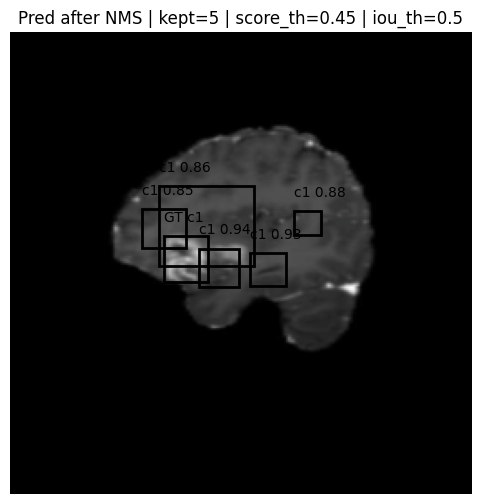

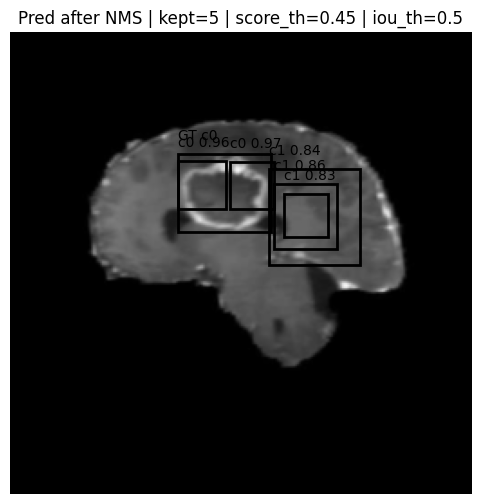

In [ ]:
show_prediction(val_ds, idx=0, score_th=0.45, iou_th=0.5, topk=5)
show_prediction(val_ds, idx=1, score_th=0.45, iou_th=0.5, topk=5)

Вывод

В работе использован датасет Ultralytics/Brain-tumor в YOLO-формате (images + labels). На базе предобученного ResNet18 (ImageNet) реализована упрощённая YOLO-like модель: выход формируется на сетке S×S с A anchors и предсказанием (tx, ty, tw, th, obj, cls) для каждого anchor. Реализована комбинированная функция потерь YOLO-like (coord + obj/noobj + cls), проведено обучение с выводом прогресса и разложением loss на части. Для постобработки реализованы decode предсказаний и NMS (class-wise), после чего выполнена визуализация результатов. По выводам лосса и примерам визуализации видно, что модель выдаёт вполне осмысленные bbox и классификацию